<a href="https://colab.research.google.com/github/mot1122/CNN_model/blob/main/use_pytorch/tuned_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pytorch_lightning=="0.7.1"

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 829 kB 43.0 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.7.1-py3-none-any.whl size=145329 sha256=acbe3922fb435190d4398ef4b4a3cbef3456343ed8080732985a7e2057b973c5
  Stored in directory: /root/.cache/pip/wheels/a5/c0/6c/ed64904da20814878f410c520ae61c062c6d7e93bf5c27dcd4
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=e961dd898a7cd944d34ea1294ee9f4a94e0007f81e7ff5293a2df38562621da0
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built pytorch-lightning future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer

# Dataset

In [14]:
transform=transforms.Compose([
  transforms.ToTensor(),  
])

In [15]:
train_val=torchvision.datasets.CIFAR10(root="data",train=True,download=True,transform=transform)
test=torchvision.datasets.CIFAR10(root="data",train=False,download=True,transform=transform)
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train
torch.manual_seed(0)
train,val=torch.utils.data.random_split(train_val,[n_train,n_val])

Files already downloaded and verified
Files already downloaded and verified


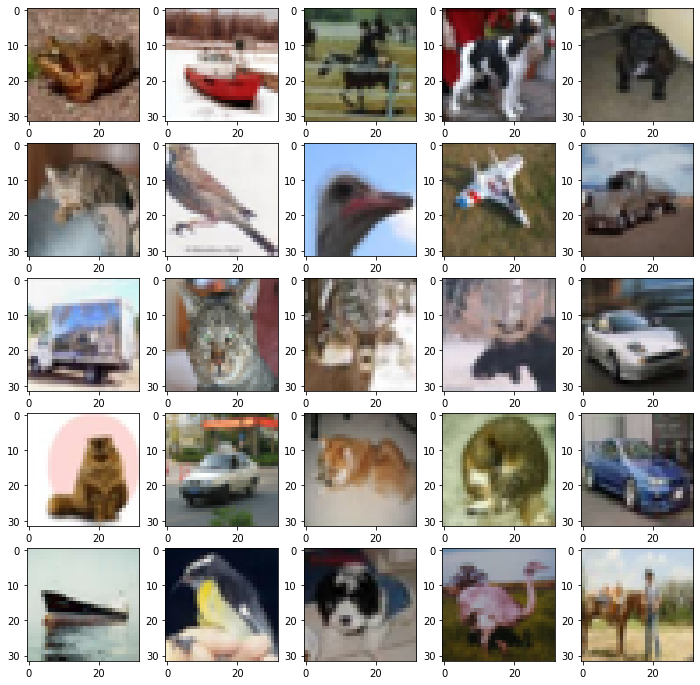

In [16]:
plt.figure(figsize=(12,12))
for i in range(25):
  img=np.transpose(train[i][0].numpy(),(1,2,0))
  plt.subplot(5,5,i+1)
  plt.imshow(img)

In [17]:
class TrainNet(pl.LightningModule):

    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)

    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        # 以下追加
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'loss': loss, 'acc': acc}
        return results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/decorators.py:13: UserWarning: data_loader decorator deprecated in 0.7.0. Will remove 0.9.0
  warnings.warn(w)


In [18]:
class ValidationNet(pl.LightningModule):

    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        return results

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        results =  {'val_loss': avg_loss, 'val_acc': avg_acc}
        return results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/decorators.py:13: UserWarning: data_loader decorator deprecated in 0.7.0. Will remove 0.9.0
  warnings.warn(w)


In [19]:
class TestNet(pl.LightningModule):

    @pl.data_loader
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/decorators.py:13: UserWarning: data_loader decorator deprecated in 0.7.0. Will remove 0.9.0
  warnings.warn(w)


In [20]:
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # 全結合層
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

1

In [11]:
trainer.test()
trainer.callback_metrics

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.5625,
 'epoch': 9,
 'loss': 1.3713335990905762,
 'test_acc': 0.5628846287727356,
 'test_loss': 1.231909155845642,
 'val_acc': 0.5609753727912903,
 'val_loss': 1.2495486736297607}

# Optimize

## SGD

In [24]:
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # 全結合層
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr=1e-2, momentum=0.9)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.265625,
 'epoch': 9,
 'loss': 1.8973145484924316,
 'test_acc': 0.3728216588497162,
 'test_loss': 1.7319992780685425,
 'val_acc': 0.3651407063007355,
 'val_loss': 1.7508045434951782}

## RMSprop

In [26]:
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # 全結合層
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.01, alpha=0.99, eps=1e-8)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.125,
 'epoch': 9,
 'loss': 2.299060106277466,
 'test_acc': 0.10010762512683868,
 'test_loss': 2.3040223121643066,
 'val_acc': 0.0980129987001419,
 'val_loss': 2.304368734359741}

## Adam

In [28]:
class Net(TrainNet, ValidationNet, TestNet):
    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # 全結合層
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.5625,
 'epoch': 9,
 'loss': 1.3701255321502686,
 'test_acc': 0.5741669535636902,
 'test_loss': 1.2119368314743042,
 'val_acc': 0.5666912794113159,
 'val_loss': 1.2307294607162476}

# Dropout

In [30]:
class Net(TrainNet, ValidationNet, TestNet):

    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
      
        self.dropout = nn.Dropout2d(p=0.5) 

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)
        # 追加
        x = self.dropout(x) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.578125,
 'epoch': 9,
 'loss': 1.3192498683929443,
 'test_acc': 0.588574230670929,
 'test_loss': 1.157011866569519,
 'val_acc': 0.583878755569458,
 'val_loss': 1.1777225732803345}

# Regularization

In [32]:
class Net(TrainNet, ValidationNet, TestNet):

    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        # weight_decay 引数を追加
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-3) 

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.578125,
 'epoch': 9,
 'loss': 1.3788509368896484,
 'test_acc': 0.5496134161949158,
 'test_loss': 1.2792749404907227,
 'val_acc': 0.5416494011878967,
 'val_loss': 1.2986063957214355}

# Batch Normalization

In [34]:
class Net(TrainNet, ValidationNet, TestNet):

    def __init__(self, batch_size=128):
        super(Net, self).__init__()    
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)
        # 追加
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128) 

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = self.bn1(x) # 追加
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = self.bn2(x) # 追加
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = self.bn3(x) # 追加
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [35]:
torch.manual_seed(0)

# モデルの準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
     
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.75,
 'epoch': 9,
 'loss': 0.7653577327728271,
 'test_acc': 0.7064253687858582,
 'test_loss': 0.8641306161880493,
 'val_acc': 0.7026666402816772,
 'val_loss': 0.8863693475723267}